<a href="https://colab.research.google.com/github/jocelynbaduria/Assignment-6_part_abcde/blob/main/Jocelyn_Baduria_cmpe258_Assignment6_a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A. Autograd in Python and Numpy MNIST Classifier with UnitTest

---

---



Initialize AutoGrad Class

Reference :

https://colab.research.google.com/drive/1kewjqN5LUZI7z5KNMxt3BV8lzEmCsbNf#scrollTo=y4aorYbzF7gi

In [236]:
class AutoGradTensor:

    def __init__(self, data, autograd=False):
        self.data = data
        if not isinstance(data, np.ndarray):
            self.data = np.array(data)
        # whether to run backpropagation or not
        self.autograd = autograd
        # tensor gradient
        self._grad = None
        # operation if this tensor was used in it
        self._grad_fn = None

    # Use Python Decorator @property to properly set the  
    @property
    def shape(self):
        return self.data.shape

    @property
    def grad_fn(self):
        if not self.autograd:
            raise Exception('This tensor is not backpropagated')
        return self._grad_fn

    @property
    def grad(self):
        return self._grad

    def backward(self, grad=None):
        if not self.grad_fn:
            return False

        if grad is None and self._grad is None:
            # in case if this is last loss tensor
            grad = self.__class__(1., requires_grad=False)

        elif self.grad is not None:
            grad = self._grad

        if not self.autograd:
            raise Exception('This tensor is not backpropagated')

        self.grad_fn.backward(grad)
        return True

    def __str__(self):
        return f'AutoGradTensor({str(self.data)})'

    def add_grad(self, grad):
        if self._grad is None:
            self._grad = grad
        else:
            self._grad += grad

    def __add__(self, o): 
        if self.data is not None:
            self.data += o.data  
            return self
        self.data = o.data 
        return self

    def model(self, x):
        if(self.autograd):
            return AutoGradTensor(self.data.dot(x.data))
        return AutoGradTensor(self.data.dot(x.data))

class Operation:

    def forward(self):
        raise NotImplemented

    def backward(self, grad):
        raise NotImplemented

    def __call__(self, *args):
        self.out = self.forward(*args)
        self.out._grad_fn = self
        return self.out

class Add(Operation):

    '''Summation operation of x and y tensors'''

    def forward(self, x: AutoGradTensor, y: AutoGradTensor):
        self.x = x
        self.y = y
        # created tensor should be backpropagated if at least one 
        # of the input is backpropagated
        autograd = x.autograd or y.autograd
        return AutoGradTensor(x.data + y.data, autograd=autograd)

    def backward(self, grad):
        if self.x.autograd:
            # as we have matrix operation one of the parameters can have partial shape
            # in such scenarion we need to sum gradient values by missed axis
            if self.x.shape != grad.shape:
                axis = np.argmax(np.abs(np.array(self.x.shape) - np.array(grad.shape)))
                self.x.add_grad(Tensor(grad.data.sum(axis=axis, keepdims=True)))
            else:
                self.x.add_grad(grad)
            if self.x.grad_fn:
                self.x.backward()
        if self.y.autograd:
            if self.y.shape != grad.shape:
                axis = np.argmax(np.abs(np.array(self.y.shape) - np.array(grad.shape)))
                self.y.add_grad(Tensor(grad.data.sum(axis=axis, keepdims=True)))
            else:
                self.y.add_grad(grad)
            if self.y.grad_fn:
                self.y.backward()

class Multiplication(Operation):
    '''Multiplication operation of x and y tensors'''

    def forward(self, x: AutoGradTensor, y: AutoGradTensor):
        self.x = x
        self.y = y
        autograd = x.autograd or y.autograd
        return AutoGradTensor(x.data * y.data, autograd=autograd)

    def backward(self, grad):
        if self.x.autograd:
            self.x.add_grad(AutoGradTensor(grad.data * self.y.data, False))
            if self.x.grad_fn:
                self.x.backward()
        if self.y.autograd:
            self.y.add_grad(AutoGradTensor(grad.data * self.x.data, False))
            if self.y.grad_fn:
                self.y.backward()

Initialize sample Tensors data

In [237]:
x = np.random.random((3,3))
a = np.random.random((3,3))
b = np.random.random((3,))

loss = np.random.random((3,3))

_x = AutoGradTensor(x,autograd=True)
_a = AutoGradTensor(a,autograd=True)
_b = AutoGradTensor(b,autograd=True)

y = Multiplication()(Add()(Multiplication()(_x, _a), _b), _a)
print('y = ', y)
print('___________________________________________________________')
y.backward(AutoGradTensor(loss))
print('_x.grad = ',_x.grad)
print('___________________________________________________________')
print('_a.grad = ',_a.grad) 
print('___________________________________________________________')
print('_b.grad = ',_b.grad) 

y =  AutoGradTensor([[0.21027291 0.06872249 0.40254438]
 [0.38253818 0.08829333 0.08513609]
 [0.60867558 0.44197597 0.4334035 ]])
___________________________________________________________
_x.grad =  AutoGradTensor([[0.03874525 0.02255446 0.1098213 ]
 [0.10960386 0.01530139 0.00074202]
 [0.5329534  0.11985912 0.29142335]])
___________________________________________________________
_a.grad =  AutoGradTensor([[0.89802351 0.13618267 0.59656182]
 [0.39453755 0.04677933 0.03224671]
 [0.86897871 0.17951117 0.67209223]])
___________________________________________________________
_b.grad =  Tensor([[1.11075508 0.28753422 0.7233977 ]])


Build Neural Network with AutoGrad

In [239]:
class Layer:

    def forward(self):
        raise NotImplemented
    
    def backward(self, grad):
        raise NotImplemented

    def __call__(self, *args):
        return self.forward(*args)

class Sigmoid:

    def forward(self, x):
        self.x = x   
        return 1/(1+np.exp(-x))
      
    def backward(self, grad):
        grad_input = self.x*(1-self.x) * grad
        return grad_input

class Relu(Layer):

    def forward(self,x):
        self.x = x
        return np.maximum(np.zeros_like(x), x)
      
    def backward(self, grad):
        grad_input = (self.x > 0) * grad
        return grad_input

# Create Softmax Cross Entropy Activation Function
class SoftmaxCrossentropyWithLogits(Layer):

    def forward(self, x, y):
        self.x = x
        self.y = y

        exps = np.exp(x) 
        self.softmax = exps / np.sum(exps, axis=-1, keepdims=True)

        logits = self.softmax[np.arange(x.shape[0]),y]
        log_likelihood = -np.log(logits)
        loss = np.sum(log_likelihood) / x.shape[0]
        return loss
    # Setting the grad = True will call the autograd function in AutoGradTensor
    def backward(self, grad=True):
        batch = self.x.shape[0]
        grad = self.softmax
        grad[np.arange(batch),self.y] -= 1
        grad = grad/batch
        return grad

class MSE(Layer):

    def forward(self, x, y):
        self.x = x
        self.y = y
        return ((x - y)**2) / (self.x.shape[0]*2)

    def backward(self, grad=None):
        # 1/2n * Sum(xi-yi)**2 
        # dx = 1/2n * Sum( x**2 -2*x*y + y**2) 
        # dx  = (2x - 2y) / 2*n = (x - y) / n
        return (self.x - self.y) / self.x.shape[0]

class Linear(Layer):

    def __init__(self, input, output, lr=0.0001):
        self.A = 2*np.random.random((input, output)) - 1
        self.b = 2*np.random.random((output)) - 1
        self.lr = lr
    
    def forward(self, x):
        self.x = x
        return np.dot(x,self.A) + self.b

    def backward(self, grad):
        # d_layer / db = 1
        b_grad = grad.mean(axis=0)*self.x.shape[0]
        # d_layer / dA = x
        A_grad = np.dot(self.x.T, grad)
        # As this layer have somee weights we need to update them using gradient descent
        # compute df / dx = df / d_layer * d_layer / dx
        # df / d_layer == grad
        grad_input = np.dot(grad, self.A.T)
        
        self.A -= A_grad * self.lr
        self.b -= b_grad * self.lr

        return grad_input

In [240]:
# Load MNIST using Pytorch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

class Model(Layer):

    def __init__(self, lr=0.00001):
        self.lr = lr
        self.layers = [
            Linear(784,100, lr=self.lr),
            Relu(),
            Linear(100,200, lr=self.lr),
            Relu(),
            Linear(200,10, lr=self.lr)        
        ]

    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

    def backward(self, grad):
        for l in self.layers[::-1]:
            grad = l.backward(grad)

        return grad


simple = transforms.Compose([
    transforms.ToTensor(), # converts to [0,1] interval
])
ds = MNIST('./mnist', download=True, transform=simple)
ld = DataLoader(ds, batch_size=2, pin_memory=True, drop_last=True) 

mm = Model()
loss = SoftmaxCrossentropyWithLogits()
_loss_avg = 0 
for e in range(7):
    for i, (img, label) in enumerate(ld):
        # convert the image to Numpy array
        x = img.view(2,-1).numpy()

        y = mm(x)
        # convert the label to numpy array
        _loss = loss(y, label.numpy())
        _loss_avg += _loss.mean() # running loss mean
        grad = loss.backward(1)
        mm.backward(grad)

        if i % 100 == 0:
            print(_loss_avg/100)
            _loss_avg = 0
            print('---------')

1.3592057599683367
---------
138.22314178902334
---------
143.78779347913914
---------
125.72511297838122
---------
118.38070169045506
---------
121.85915298688248
---------
111.85282221876847
---------
115.74080118874299
---------
117.63538996943821
---------
90.2813031666372
---------
107.89466760236363
---------
89.51646506181004
---------
95.7910936547284
---------
101.22054447258675
---------
94.32271920668862
---------
78.95418641852567
---------
84.15424016752979
---------
86.04635315644255
---------
85.8986690395971
---------
79.81488106893472
---------
83.64242205545496
---------
79.8692349734792
---------
81.94355406657972
---------
76.27011100698796
---------
79.2919534579962
---------
76.68505695280852
---------
74.90713832387905
---------
78.05875050177823
---------
68.32154075058172
---------
72.84459642576913
---------
68.91286024779265
---------
74.52253817265382
---------
66.50278163930676
---------
71.1348297408283
---------
54.212045254165915
---------
70.68603219330

MNIST Classifier

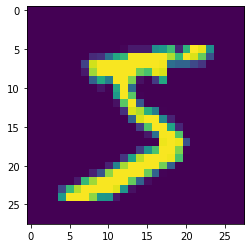

target: 5 predicted: 5


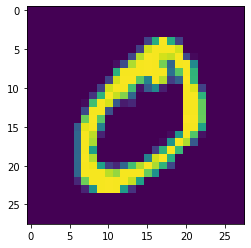

target: 0 predicted: 0


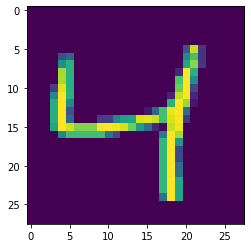

target: 4 predicted: 7


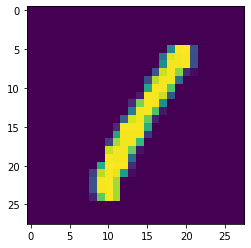

target: 1 predicted: 1


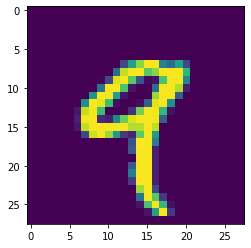

target: 9 predicted: 9


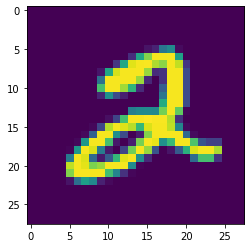

target: 2 predicted: 2


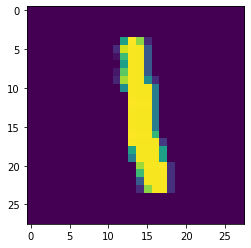

target: 1 predicted: 1


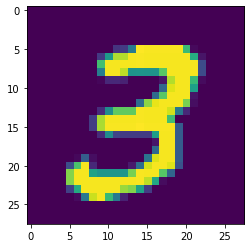

target: 3 predicted: 3


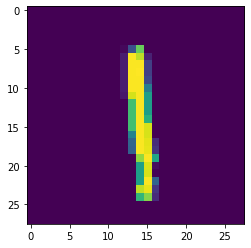

target: 1 predicted: 1


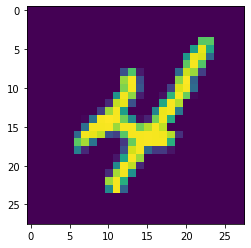

target: 4 predicted: 4


In [241]:
import matplotlib.pyplot as plt

for i in range(10):
    img, target = ds[i]
    plt.imshow(img[0])
    plt.show()
    x = img.view(1,-1).numpy()
    res = mm(x)[0]
    pred = np.argmax(res)
    print(f'target: {target} predicted: {pred}' )